# Autoencoders
In this notebook we will develop a simple autoencoder in pytorch.<br>
Autoencoders fall under the unsupervised family, and thier purpose is to learn an encoding of the 
data, where the immediate use cases are dimensionality reduction and denoising.<br>
Autencoders where first purposed by [Rumelhart](https://apps.dtic.mil/docs/citations/ADA164453) under Hinton supervision. <br><br>

## Intution
The best way to start explaining an autoencoder is by observing the following visualization: 
![alt text](img/cells.png "Title")

The first thing we notice is that the input and output layer have the same size. <br>
This is because our "goal" is that the input and the output will be exactly the same! To put antoher way, if we input $x$ we want to get $x$ as the output.<br>
The second thing we notice is that we have a hidden layer with a lower dimensionality than the input and output layer. This is where our "encoding" hides, we want to shrink the input, and still be able to recover it.

## Theory
Mathmetically you can define an autoencoder operating on real values using the following tuple :
- $n, p$ are integers. (in the above visualiztion $n=8$ and $p=3$)
- $f$ a function $f:\mathbb{R}^n\rightarrow \mathbb{R}^p$ 
- $g$ a function $g:\mathbb{R}^p\rightarrow \mathbb{R}^n$ <br>
Under this definition, given an input $x\in \mathbb{R}^n$ an autoencoder output is simply the composition $g\circ f(x)$ <br>

Let's extend this to formulate the trainig.
- $F$ a family of functions  $f:\mathbb{R}^n\rightarrow \mathbb{R}^p$ 
- $G$ a family of functions $g:\mathbb{R}^p\rightarrow \mathbb{R}^n$ <br>
- $X=\{x_1, x_2, \ldots, x_m\}$ is our training set. $\forall i ~ x_i \in \mathbb{R}^n$
- $L$ will be a loss measure $ L : \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R}$

Our goal in the training will be to find $f^* \in F$ and $g^* \in G$ that will bring 
$\sum_X L(x_i, g\circ f(x_i))$ to a minimum.<br>
$F, G$ will be a family of nerual nets for our purposes, in the following examples 
we will use : TODO (fill out network specifity).


## Theroy out <- -> Parctice in
So now that we don't understand what excatly are these autoencoders since we only heard about the theory let's try
and code one.
### Data set
As in all hello world tutorials we will work on the mnist dataset(accesible and insights are easy to gain).
We will try to build an autoencoder with a specific task - encode each digit into a single value and then decode that value back to a similar looking digit.
The network will look like this : ![alt text](img/mnist_ae.png "Title")
### Let's code!
We're going to code using pytorch!<br>
First thing first let's import all the relevant libraries for the rest of this document.
# Imports

In [590]:
# Torch impors
import torch
from torch import nn
from torchvision import transforms
import torchvision.datasets as datasets

# Tools Imports
import matplotlib.pyplot as plt
import numpy as np

# Convience Imports
from tqdm import tqdm

## Grabbing the Mnist dataset using PyTorch.

In [593]:
# The dataset comes as np array and we want to convert it to tensor. This is the easiest way to do so.
image_transofrm = transforms.Compose([transforms.ToTensor()
    ])

mnist_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               download=True, 
                               transform=image_transofrm)

# Worth mentioning that we don't really need a test set but it is good to look at the 
# Results the autoencoder produces on the test to see it did not overfit.
mnist_test = datasets.MNIST(root='./data',
                           train=True, 
                           download=True, 
                           transform=image_transofrm)

data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

# Encoder 

In [752]:
from torch import nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(784, 50),
            nn.ReLU(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(50, 2),
        )
        
        self.layers = [self.fc1, self.fc2, self.fc3]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    

# Decoder

In [753]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layers = []
        self.fc1 = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),            
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(50, 784),
            nn.Sigmoid()
        )
        
        self.layers = [self.fc1, self.fc2, self.fc3]
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            
        return x

# Let's build the Network Objects

In [754]:
encoder = Encoder()
decoder = Decoder()

# Optimization Algorithm
We will use the RMSprop optimizer for no apparent reason (Some shaddy online resource).

In [755]:
encoder_optimizer = optim.RMSprop(encoder.parameters(), lr=0.0001)
decoder_optimizer = optim.RMSprop(decoder.parameters(), lr=0.0001)

loss = nn.MSELoss()

# Let's train! 

In [ ]:
EPOCHS = 200

errors = [] # we save the errors throughout the training to visualize the training process once it is done.

for _ in tqdm(range(EPOCHS)):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        flat_image = images_to_vectors(real_batch)
        x_encoded = encoder(flat_image)
        y = decoder(x_encoded)
        
        error = loss(flat_image, y)
        errors.append(error.item() / 64)
        error.backward()
        
        decoder_optimizer.step()
        encoder_optimizer.step()

 88%|████████▊ | 176/200 [16:30<02:15,  5.63s/it]

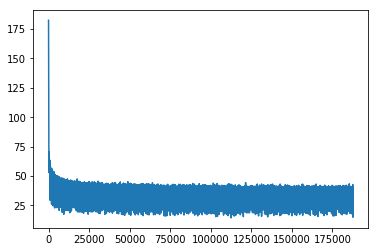

In [741]:
import matplotlib.pyplot as plt
plt.plot(errors)

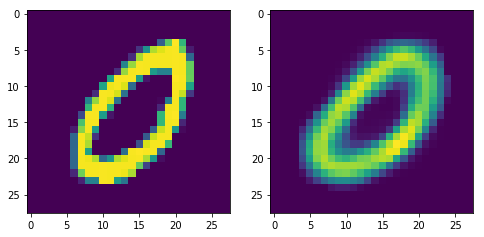

In [751]:
# Looking at the encoder function
def encode_decode(image):
    global encoder
    global decoder
    
    encoder.eval()
    decoder.eval()
    image_encoded = encoder(image)
    return decoder(image_encoded)

random_image = mnist_test[np.random.randint(0,6000)]
image, label = random_image[0], random_image[1]
sample = images_to_vectors(image)

reconstruction = encode_decode(sample)
reconstruction = vectors_to_images(reconstruction)

figure, axes = plt.subplots(1,2, figsize=(8, 4))
axes[0].imshow(image[0])
axes[1].imshow(reconstruction.detach().numpy()[0][0])

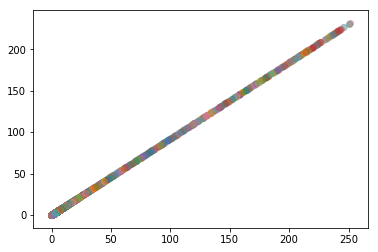

In [694]:
rndpm = np.random.permutation(np.arange(100))
for n, instance in enumerate(mnist_dataset):
    if n < 5000:
        n+=1
        image, label = instance[0], instance[1]
        encoded_image = encoder(images_to_vectors(image))
        point = encoded_image[0]
        plt.scatter(point[0].item(), point[1].item(), alpha=0.3)
    